In [1]:
import os
import sys
import random
import warnings

import pathlib
import numpy as np
import pandas as pd

from skimage.color import rgb2gray

import time

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, UpSampling2D,Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import metrics

import tensorflow as tf

import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

import imageio



/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
folders = []
training_set = dict()
idx = 0

p = pathlib.Path("DATA/train/")

#Looking for all the folders existing in train folder
for i in p.glob('*'):
    
    path = "DATA/train/"
    path += i.name;
    
    f_path = pathlib.Path(path)
    folders.append(f_path)


for p in folders:
    
    im_p = str(p)
    im_p += "/images/"
    ma_p = str(p)
    ma_p += "/masks/"
    
    #First, we set the paths for the image and the masks

    im_path = pathlib.Path(im_p)
    ma_path = pathlib.Path(ma_p)

    
    #Then, we read the image
    name =""
    for i in im_path.glob('*.png'):
        name = i.name
    im_p += name
    im = rgb2gray(imageio.imread(im_p))

    
    masks = []
    #Then, we read every sub mask
    maskp = ma_p
    for i in ma_path.glob('*.png'):
        name =""
        name = i.name
        ma_p = maskp
        ma_p += name
        sub_mask = imageio.imread(ma_p)
        masks.append(sub_mask)
    
    mask = masks[0]
    for m in masks: 
        mask = np.where((mask + m) > 200, 255, 0)
        #Finaly, we regroup every sub mask in a single one.

        
    #We add the image and its mask to the dictionary    
    training_set[idx] = (im, mask)
    idx += 1



In [3]:
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) 
    return lerp(x1,x2,v) 

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,2,256,endpoint=False)
x,y = np.meshgrid(lin,lin)

im_p = perlin(x,y,seed=random.randint(5,20))

In [4]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size, image,borderMode=cv2.BORDER_REFLECT_101)
    
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))


In [5]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

def elastoperlin_transformation(im ,mask,elast, perl, shape):
    lina = np.linspace(0,1,shape[0],endpoint=False)
    linb = np.linspace(0,1,shape[1],endpoint=False)
    a,b = np.meshgrid(linb,lina)
    if perl:
        im_p = perlin(a,b,seed=random.randint(1,20000))
        im_p = np.abs(im_p)
        im_p = np.array((normalize(im_p)*4000), dtype = np.uint8)
        #im_p = np.concatenate((im_p[...,None], im_p[...,None],im_p[...,None]), axis=2)
        im = im + im_p
    if elast:
        im = np.concatenate((im[...,None], mask[...,None]), axis=2)
        im = elastic_transform(im,im.shape[1]*2,im.shape[1]*0.1,im.shape[1]*0.08) 
        mask = im[:,:,1:]
        im = im[:,:,0]
    im = cv2.copyMakeBorder(im,92,92,92,92,cv2.BORDER_REFLECT) 
    # 92 représente la marge rognée par les convolutions successives
    return im, mask

In [6]:
def imaskdivision(im,mask,shape, padding):
    # padding est la taille de la marge non masquée (92)
    # shape est la shape maximale d'un echantillon (132,132) dans notre cas
    ims = []
    masks = []
    widthDiv = int(np.ceil(float(im.shape[0]-(2*padding))/float(shape[0])))
    heightDiv = int(np.ceil(float(im.shape[1]-(2*padding))/float(shape[1])))
    for i in range(widthDiv):
        for j in range(heightDiv):
            if i == widthDiv-1:
                sw = im.shape[0]-(shape[0]+padding)
            else:
                sw = padding + shape[0]*i
                
            if j == heightDiv-1:
                sh = im.shape[1]-(shape[1]+padding)
            else:
                sh = padding + shape[1]*j
            
            imseg = im[sw-padding:sw+shape[0]+padding,sh-padding:sh+shape[1]+padding]
            ims.append(imseg)
            maskseg = mask[sw-padding:sw+shape[0]-padding,sh-padding:sh+shape[1]-padding]
            maskseg = (maskseg>0)
            masks.append(maskseg)
    return ims,masks

def dataAugmentation(im, mask, rate):
    train = []
    labels = []
    for i in range(rate):
        imtemp, masktemp = elastoperlin_transformation(im, mask, True, True,np.shape(im))
        ims, masks = imaskdivision(imtemp, masktemp,(132,132),92)
        for image in ims:
            train.append(image)
        for m in masks:
            labels.append(m)
    return train , labels        
    
        

In [7]:
train = []
labels = []

for i in range(10):
    im, mask = training_set[i]
    ims , masks = dataAugmentation(im,mask,2)
    print i, " images traitées"
    for image in ims:
        train.append(np.reshape(image,(316,316,1)))
    for m in masks:
        labels.append(np.reshape(m, (132,132,1)))



0  images traitées
1  images traitées
2  images traitées
3  images traitées
4  images traitées
5  images traitées
6  images traitées
7  images traitées
8  images traitées
9  images traitées


In [8]:
del training_set

In [9]:
# Initialisation des variables
height = 316
width = 316
depth = 1
batchsize = 1
size_augmented = 440
kernel3x3= (3,3)


In [10]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

In [11]:
def weightLoss(y_true, y_pred):
    [mask, weight] = tf.unstack(y_true, 2, axis=3)
    weighted_pred = y_pred*weight
    weighted_mask = mask*weight
    return binary_crossentropy(weighted_mask, weighted_pred)

In [12]:
inputLayer = Input(( height, width, depth))

normalise = Lambda(lambda x: x / 255) (inputLayer)

conv11 = Conv2D(16, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(normalise)
conv12 = Conv2D(16, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(conv11)
pool1 = MaxPooling2D((2,2))(conv12)
conv21 = Conv2D(32, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool1)
conv22 = Conv2D(32, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(conv21)
pool2 = MaxPooling2D((2,2))(conv22)
conv31 = Conv2D(64, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool2)
conv32 = Conv2D(64, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(conv31)
pool3 = MaxPooling2D((2,2))(conv32)
conv41 = Conv2D(128, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool3)
conv42 = Conv2D(128, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(conv41)
pool4 = MaxPooling2D((2,2))(conv42)
conv51 = Conv2D(256, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool4)
conv52 = Conv2D(256, kernel3x3, padding='valid', activation='relu', kernel_initializer='random_uniform')(conv51)



upconv1 = UpSampling2D(size=(2, 2))(conv52)
ch, cw = get_crop_shape(conv42, upconv1)
cropconv4 = Cropping2D(cropping=(ch,cw))(conv42)
up1   = concatenate([upconv1, cropconv4], axis=3)
conv61 = Conv2D(128, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(up1)
conv62 = Conv2D(128, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(conv61)


upconv2 = UpSampling2D(size=(2, 2))(conv62)
ch, cw = get_crop_shape(conv32, upconv2)
cropconv3 = Cropping2D(cropping=(ch,cw))(conv32)
up2  = concatenate([upconv2, cropconv3], axis=3)
conv71 = Conv2D(64, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(up2)
conv72 = Conv2D(64, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(conv71)


upconv3 = UpSampling2D(size=(2, 2))(conv72)
ch, cw = get_crop_shape(conv22, upconv3)
cropconv2 = Cropping2D(cropping=(ch,cw))(conv22)
up3  = concatenate([upconv3, cropconv2], axis=3)
conv81 = Conv2D(32, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(up3)
conv82 = Conv2D(32, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(conv81)

upconv4 = UpSampling2D(size=(2, 2))(conv82)
ch, cw = get_crop_shape(conv12, upconv4)
cropconv1 = Cropping2D(cropping=(ch,cw))(conv12)
up4  = concatenate([upconv4, cropconv1], axis=3)
conv91 = Conv2D(16, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(up4)
conv92 = Conv2D(16, kernel3x3, padding="valid", activation="relu", kernel_initializer='random_uniform')(conv91)

outputconv = Conv2D(1, (1, 1), activation="sigmoid")(conv92)


u_net = Model(inputs= inputLayer, outputs = outputconv)

u_net.compile(optimizer='adam', loss='binary_crossentropy', metrics =[metrics.binary_accuracy])
u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 316, 316, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 316, 316, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 314, 314, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 312, 312, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [16]:
train = np.array(train)
labels = np.array(labels)
earlystopper = EarlyStopping(patience=2, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018.h5', verbose=1, save_best_only=True)
results = u_net.fit(train, labels, validation_split=0.2, batch_size=4, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 65 samples, validate on 17 samples
Epoch 1/10
65/65 [==============================] - 42s 653ms/step - loss: 0.6268 - binary_accuracy: 0.8747 - val_loss: 0.6027 - val_binary_accuracy: 0.8880

Epoch 00001: val_loss improved from inf to 0.60267, saving model to model-dsbowl2018.h5
Epoch 2/10
65/65 [==============================] - 42s 644ms/step - loss: 0.5912 - binary_accuracy: 0.8747 - val_loss: 0.5694 - val_binary_accuracy: 0.8880

Epoch 00002: val_loss improved from 0.60267 to 0.56942, saving model to model-dsbowl2018.h5
Epoch 3/10
65/65 [==============================] - 42s 647ms/step - loss: 0.5614 - binary_accuracy: 0.8747 - val_loss: 0.5405 - val_binary_accuracy: 0.8880

Epoch 00003: val_loss improved from 0.56942 to 0.54053, saving model to model-dsbowl2018.h5
Epoch 4/10
65/65 [==============================] - 42s 651ms/step - loss: 0.5355 - binary_accuracy: 0.8747 - val_loss: 0.5154 - val_binary_accuracy: 0.8880

Epoch 00004: val_loss improved from 0.54053 to 0.515

In [17]:
p_test = u_net.predict(train, batch_size = 1, verbose=1)

82/82 [==============================] - 16s 194ms/step


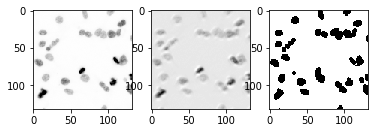

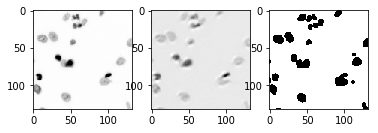

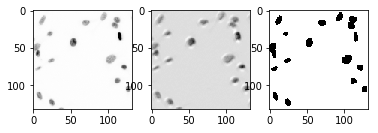

In [28]:
for k in range(3):
    
    plt.figure(1)
    
    plt.subplot(131)
    plt.imshow(train[k,92:224,92:224,0], interpolation="nearest",cmap ="Greys")
    plt.subplot(132)
    plt.imshow(np.reshape((p_test[k]),(132,132)), interpolation="nearest",cmap ="Greys")

    plt.subplot(133)
    plt.imshow(np.reshape(labels[k],(132,132)),interpolation="nearest",cmap ="Greys")
    plt.show()
